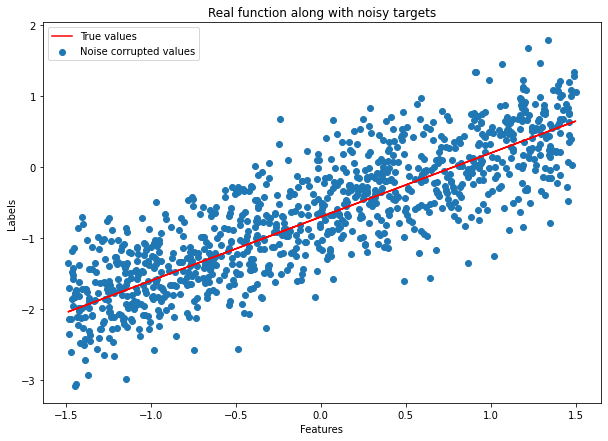

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal

# Generate noisy dataset
seed = 42
np.random.seed(seed)

n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5


train_points = np.random.uniform(lower_bound, upper_bound, n_datapoints)
noisy_labels = slope * train_points + intercept + np.random.normal(0, noise_std_dev, n_datapoints)
true_labels = slope * train_points + intercept

# Plot the dataset
plt.figure(figsize=(10,7))
plt.plot(train_points, true_labels, color='r', label="True values")
plt.scatter(train_points, noisy_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();


In [22]:
feature_dim = 2

feature_matrix = np.stack((np.ones(n_datapoints),train_points), axis=1)

precision = 0.2
prior_mean = np.zeros(feature_dim)
prior_cov = np.identity(feature_dim) * (1.0/precision)

prior = multivariate_normal(prior_mean, prior_cov)



In [23]:
inverse_mat = np.linalg.inv(np.dot(feature_matrix.T, feature_matrix) + noise_var * precision * np.identity(feature_dim))

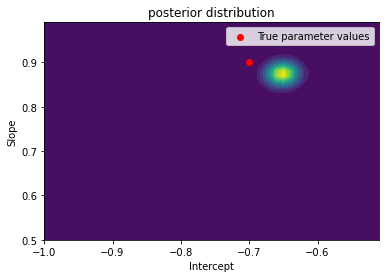

In [24]:
# Compute the posterior distribution
posterior_mean = np.dot(inverse_mat, np.dot(feature_matrix.T, noisy_labels))
posterior_cov = noise_var * inverse_mat

posterior = multivariate_normal(posterior_mean, posterior_cov)

# Plot the posterior distribution
fig = plt.figure()
mesh_features, mesh_labels = np.mgrid[-1.0:-0.5:.01, 0.5:1.0:.01]
pos = np.dstack((mesh_features, mesh_labels))
plt.contourf(mesh_features, mesh_labels, posterior.pdf(pos), levels=15)
plt.scatter(intercept, slope, color='red', label="True parameter values")
plt.title("posterior distribution")
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

In [25]:
# Check posterior predictive distribution
n_test_points = 10

test_points = np.random.uniform(lower_bound, upper_bound, n_test_points)



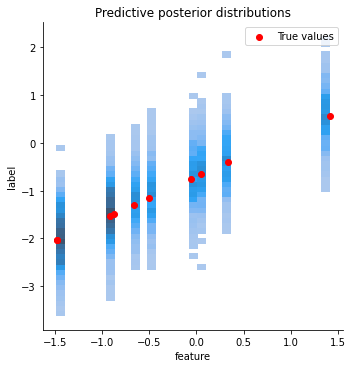

In [39]:
import pandas as pd
import seaborn as sns

all_rows = []
sample_size = 1000

true_labels = slope * test_points + intercept

for point in test_points:
    test_features = np.stack((np.ones(1), np.array([point])), axis=1)
    pred_mean = test_features.dot(posterior_mean)
    pred_cov = test_features.dot(posterior_cov.dot(test_features.T)) + noise_var
    predictive = univariate_normal(pred_mean.flatten(), math.sqrt(pred_cov))
    
    sample_predicted_labels = predictive.rvs(size=sample_size)
    for label in sample_predicted_labels:
        all_rows.append([point, label])
    
all_data = pd.DataFrame(all_rows, columns=["feature", "label"]) 
sns.displot(data=all_data, x="feature", y="label")
plt.scatter(x=test_points, y=true_labels, color="red", label="True values")
plt.title("Predictive posterior distributions")
plt.legend()
plt.plot();


In [44]:
import math

# Compute log marginal likelihood
log_ml = 0
for i in range(0, n_datapoints):
    train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
    pred_mean = train_features.dot(posterior_mean)
    pred_cov = train_features.dot(posterior_cov.dot(train_features.T)) + noise_var
    predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))
    
    true_label = train_points[i] * slope + intercept
    # print("true output: " + str(true_label), "pred mean: " + str(pred_mean), "pred covariance: " + str(pred_cov), "pred probability: " + str(predictive.pdf(true_label)))
    log_ml += math.log(predictive.pdf(true_label))
    
print("Log Marginal Likelihood on the training set: " + str(log_ml))

Log Marginal Likelihood on the training set: -232.7000606474509


# Harmonic Mean Estimator

We want to estimate the marginal likelihood, because normally it impossible to analyically calculate the exta vaule of it for arbitrary distribution. Harmonic Mean Estimator is an estimator based on Simple Importance Sampling(SIS), which could estimate the marginal likelihood through the posterior and the prior. The formula below shows the relation between these three distribution:
\begin{equation}
 E_{\omega \sim p(\omega|y)}\left[ \frac{p(\omega)}{p(\omega, y)}\right] = \frac{1}{p(y)}
\end{equation}

Following this formula we first sample from the posterior $p(\omega, y)$ and then calculate the ratio of prior and posterior which is the reciprocal of the predictive distribution:
\begin{equation}
 \frac{p(\omega)}{p(\omega,y)} = \frac{1}{p(y|\omega)}
\end{equation}

Therefore we apply the sample to the predictive distribution and add the result together to obtian the unbiased estimation of the reciprocal of the marginal likelihood.

To compute the predictive distribution over all data points with given model parameter, we use the following formula:
\begin{equation}
 p(y|\omega) = \prod_{i = 1}^{N}p(y_i|\omega) = \exp{\sum_{i = 1}^{N} \log(p(y_i|\omega))}
\end{equation}
Because directly calculate the producte of the value for each data point might lead to numerical underflow.


In [88]:
# Harmonic Mean Estimator

# Samples need to be from the posterior
def harmonic_mean_estimator(samples):
    denominator = 0
    for k in range(0, len(samples)):
        sum_logs = 0

        print("current sample: " + str(samples[k]))
        for i in range(0, n_datapoints):
            train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
            true_label = train_points[i] * slope + intercept
            pred_mean = train_features.dot(samples[k])
            pred_cov = noise_var
            predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))

            sum_logs += math.log(predictive.pdf(true_label))

        dataset_likelihood = math.exp(sum_logs)
        denominator += 1.0 / dataset_likelihood

    ML_estimate = K / denominator
    return ML_estimate


# With ground truth samples
K = 20
true_samples = posterior.rvs(size=K)
ML_estimate = harmonic_mean_estimator(true_samples)
print("Estimated Log Marginal Likelihood on the training set: " + str(math.log(ML_estimate)))

current sample: [-0.63941374  0.86048331]
current sample: [-0.66288836  0.88585238]
current sample: [-0.65724275  0.86853778]
current sample: [-0.64535749  0.89577766]
current sample: [-0.6573818  0.8881476]
current sample: [-0.63011593  0.87762024]
current sample: [-0.65027606  0.86744352]
current sample: [-0.66630267  0.85117157]
current sample: [-0.66863531  0.87020811]
current sample: [-0.66145513  0.89949829]
current sample: [-0.64659614  0.88790212]
current sample: [-0.62792999  0.8718106 ]
current sample: [-0.65938437  0.83396306]
current sample: [-0.68440214  0.85857382]
current sample: [-0.65366687  0.85267444]
current sample: [-0.63884826  0.85938739]
current sample: [-0.65683773  0.87094085]
current sample: [-0.65353138  0.86859101]
current sample: [-0.66553997  0.86829261]
current sample: [-0.65884619  0.89311064]
Estimated Log Marginal Likelihood on the training set: -235.31435015233134


# Markov Chain Monte Carlo
In practice we usually cannot sample from the true posterior, because we cannot compute it analytically. Therefore, we use Markov Chain Monte Carlo (MCMC) sampling to obtain approximate samples from the posterior without knowing its true form. The only constraint is that we have to be able to evaluate a function $f$ that is proportional to the posterior. The posterior can be decomposed using Bayes rule to this: 
\begin{equation}
p(w|X, y) = {p(y|X, w)p(w) \over p(y|X)} = {p(y|X, w)p(w) \over \int p(y|X, w)p(w)dw}
\end{equation}
Even if we do not know the analytical form of the posterior because we cannot solve the integral in the denominator, we can still evaluate the numerator. Since it is proportional to the posterior, it is valid for us to define 
\begin{equation}
f(w) = p(y|X, w)p(w)
\end{equation}

We use the Metropolis algorithm to define our acceptance probabilities and thereby also our transition probabilities of the Markov Chain. The idea is to define the transition probabilities such that the Markov Chain's stationary distribution is identical to our target distribution, the posterior distribution. This can be achieved by fulfilling the "detailed balance condition": $p(a)T(a \rightarrow b) = p(b)T(b \rightarrow a)$, where $T(a \rightarrow b)$ denotes the probability of transitioning from a to b. Let $g(b|a)$ denote our proposal distribution for a new sample b given the current sample a. Additionally, let $A(a \rightarrow b)$ denote the probability of accepting such a transition from a to b. Using our proportional function $f$ and the above definitions, the detailed balance condition can be written as such:

\begin{equation}
{f(a) \over NC})g(b|a)A(a \rightarrow b) = {f(b) \over NC}g(a|b)A(b \rightarrow a)
\end{equation}

The Metropolis algorithm derives acceptance probabilities that fulfill the above condition:
\begin{equation}
A(a \rightarrow b) = min(1, {f(b) \over f(a)})
\end{equation}

The proposal distribution needs to be symmetric for the above definition, in the code below we simply use a Gaussian distribution centered at the current sample with a small variance: $g(b|a) = \mathcal{N}(b|a, 0.05 \cdot I)$

By defining the transition probabilities as described above, we achieve that our Markov Chain has the posterior distribution as its stationary distribution. This means once the chain has converged to the stationary distribution, the distribution of states over many iterations of the Markov Chain will resemble the posterior distribution. The visited states can be used as approximate samples from the posterior distribution. Since the Markov Chain needs to converge to the stationary distribution first, it is common practice to discard the first $m$ iterations of the Markov Chain, where $m$ is a large number. We use $m=400$ in the code below. This initial phase is commonly referred to as the "Burn-In" phase. For our toy example, we let the Markov Chain run for 500 iterations and discard the first 400 steps. Thus, we obtain 100 approximate samples from the posterior distribution.

We observe that the last 100 samples are identical in some runs, which means none of the last 100 proposed samples was accepted. We assume that this might be due to our proposal distribution having too much variance, i.e. once we have converged to the value with the highest probability, it is very unlikely that it will propose another value with a probability that is not much smaller. We assume that this effect is amplified by the fact that our true posterior is a very narrow distribution, since we have observed $n=1000$ datapoints and only have to estimate 2 parameters (slope and intercept).

Every computation of $f(w)$ involves computing $p(y|X, w)$. Since $y$ denotes the ground truth labels of the entire dataset, we actually need to compute $p(y|X, w) = \prod_{i=1}^n p(y_i|X, w)$. To avoid a numerical underflow when multiplying very small numbers repeatedly, we rewrite the expression to $exp(log(\prod_{i=1}^n p(y_i|X, w))) = exp(\sum_{i=1}^{n} log(p(y_i|X, w)))$. Still, taking the exponential of a large negative number can result in an underflow. Since we are never interested in the exact value of $f$ but rather the ratio of $f$ evaluated at two different locations $a$ and $b$, we can also avoid this evaluation:

\begin{equation}
{f(b) \over f(a)} = {\prod_{i=1}^n p(y_i|X, b) \over \prod_{i=1}^n p(y_i|X, a)} = {exp(\sum_{i=1}^{n} log(p(y_i|X, b))) \over exp(\sum_{i=1}^{n} log(p(y_i|X, a)))} = exp(\sum_{i=1}^{n} log(p(y_i|X, b)) - \sum_{i=1}^{n} log(p(y_i|X, a)))
\end{equation}

While this fixes the underflow issue, it can now happen that the second sum of logs is so much smaller than the first one, that the difference is a large positive number and an overflow happens when evaluating the $exp$ function. Therefore, we implement a last trick to account for this: We defined our acceptance probability as $A(a \rightarrow b) = min(1, {f(b) \over f(a)})$. The second expression inside the $min$ only needs to be evaluated if it is smaller than 1. To check, whether ${f(b) \over f(a)} < 1$, it is equivalent to check, whether $\sum_{i=1}^{n} log(p(y_i|X, b)) - \sum_{i=1}^{n} log(p(y_i|X, a)) < log({p(b) \over p(a)})$. In other words, we only need to evaluate the $exp$ expression if the difference between the sum of logs is negative or zero, thus we also avoid the overflow problem.

In [89]:
# With MCMC samples

import random

current_sample = prior.rvs()
print("initial sample: " + str(current_sample))

# Loop over dataset to calculate dataset likelihood for a given sample
sum_logs = 0
for i in range(0, n_datapoints):
    train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
    true_label = train_points[i] * slope + intercept
    pred_mean = train_features.dot(current_sample)
    pred_cov = noise_var
    predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))

    sum_logs += math.log(predictive.pdf(true_label))
    
log_dataset_likelihood_current = sum_logs
print("log dataset_likelihood: " + str(log_dataset_likelihood_current))

posterior_samples = []

# Iterations of Markov Chain
for j in range(0, 500):
    
    proposal_sample = multivariate_normal(current_sample, np.identity(2) * 0.05).rvs()
    
    # Loop over dataset to calculate dataset likelihood for a given sample
    sum_logs = 0
    for i in range(0, n_datapoints):
        train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
        true_label = train_points[i] * slope + intercept
        pred_mean = train_features.dot(proposal_sample)
        pred_cov = noise_var
        predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))

        sum_logs += math.log(predictive.pdf(true_label))
        
    log_dataset_likelihood_proposal = sum_logs
    
    # Calculate the ratio of f_proposal and f_current. We avoid computing f directly, 
    # because it involves taking exp of a large negative number and will yield zero.
    difference = log_dataset_likelihood_proposal - log_dataset_likelihood_current
    prior_ratio = prior.pdf(proposal_sample) / prior.pdf(current_sample)
    
    if difference < math.log(prior_ratio):
        f_ratio = math.exp(log_dataset_likelihood_proposal - log_dataset_likelihood_current) * prior_ratio
    else: 
        f_ratio = 1
    
    acceptance_prob = min(1.0, f_ratio)
    r = random.uniform(0, 1)
    
    if r < acceptance_prob: # accept
        current_sample = proposal_sample
        log_dataset_likelihood_current = log_dataset_likelihood_proposal
    
    posterior_samples.append(current_sample)
    print(current_sample)

initial sample: [-0.85759159  0.96017895]
log dataset_likelihood: -282.1343839088461
[-0.78631888  0.76040012]
[-0.61749978  0.88062687]
[-0.61749978  0.88062687]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.70844753  0.83550366]
[-0.7

[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.68704536  0.90003091]
[-0.69602072  0.9199121 ]
[-0.69602072  0.9199121 ]
[-0.69602072  0.9199121 ]
[-0.69602072  0.9199121 ]
[-0.69602072  0.9199121 ]
[-0.69602072  0.9199121 ]
[-0.69602072

In [90]:
ML_estimate = harmonic_mean_estimator(posterior_samples[-100:])
print("Estimated Log Marginal Likelihood on the training set: " + str(math.log(ML_estimate)))

current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87314896]
current sample: [-0.70620841  0.87